# 0 - Instalation of modules

In [ ]:
#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# 1 - Importing modules

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# 2 - Get all files needed

In [2]:
data_folder = "../../Dataset/Movie/"

In [15]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId")

# 3 - Transforming data

In [16]:
#Séparation en ligne du dataframe en petits dataframe
N = 1000
data_list = []
L = data.shape[0]

for i in range(1,N+1):
    debut = int((i-1)*L/N)
    fin = int(i*L/N)
    data_list.append(data.iloc[debut:fin, :])

In [17]:
#pivot table de chaque petits dataframe
pv_list = []
N = len(data_list)

i = 0
for d in tqdm(data_list):
    pv_list.append(d.pivot_table(index="userId", columns="title", values="rating", dropna=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
#Réunir tous les pivots tables selon le film
titles = data.title.unique()
dico = {title : [] for title in titles}

for pv in pv_list:
    for title in pv:
        dico[title].append(pv[title])

In [19]:
#Concatener tous les pivots tables selon leur film et on les gardes uniquement si ils ont pas trop d'éléments manquant.
all_df = []
keep_title = []
thresh = 0.3

i = 0
for title in tqdm(titles):
    tmp = pd.concat(dico[title], axis=0)
    if not (np.sum(tmp.isna(), axis=0) > tmp.shape[0]*thresh):
        all_df.append(tmp)
        keep_title.append(title)

  0%|          | 0/58958 [00:00<?, ?it/s]

In [ ]:
#On met tous les données dans un seul dataframe
userId_title_df = pd.DataFrame(index=np.sort(data.userId.unique()), columns=keep_title)

for df in tqdm(all_df):
    index = df.index
    values = df.values
    title = df.name

    for i in range(len(index)):
        userId_title_df.iloc[index[i]-1][title] = values[i]

userId_title_df.to_csv(f"{data_folder}userId_title_df.csv", sep=";")

In [3]:
#Si la dataframe a déjà été exporté, on peut le récupérer localement
if not ("userId_title_df" in locals()):
    userId_title_df = pd.read_csv(f"{data_folder}userId_title_df.csv", sep=";")

In [4]:
userId_title_df = userId_title_df.dropna(axis=0, thresh=50)

# 4 - Colaborative filtering
## 4.1 - Find cluster
### 4.1.1 - Cosine distance

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [6]:
def standardize(row):
    return row - np.mean(row)

userId_title_std = userId_title_df.apply(standardize, axis=1).fillna(0)
userId_title_std.shape

(16893, 132)

In [72]:
cos = cosine_similarity(userId_title_std)
eps = 0.8

In [73]:
L = len(cos)
cluster = []

for i in tqdm(range(L)):
    cluster.append({"+" : [], "-" : []})
    for j in range(i+1, L):
        tmp = cos[i,j]
        if (tmp >= eps):
            cluster[i]["+"].append(j)
        elif (tmp <= -eps):
            cluster[i]["-"].append(j)

  0%|          | 0/16893 [00:00<?, ?it/s]

In [74]:
def guess_rate_cluster(user, title):
    if (len(cluster[user]["+"]) == 0):
        return 2.5
    else:
        rate = 0
        coeff = 0

        for u in cluster[user]["+"]:
            if not (pd.isnull(userId_title_df.iloc[u][title])):
                rate += cos[user, u]*userId_title_df.iloc[u][title]
                coeff += cos[user, u]
                
        for u in cluster[user]["-"]:
            if not (pd.isnull(userId_title_df.iloc[u][title])):
                rate += cos[user, u]*userId_title_df.iloc[u][title]
                coeff += cos[user, u]

        if (coeff == 0):
            return 2.5
        else:   
            return rate/coeff

In [75]:
def guess_rate_all(user, title):
    L = len(cos)
    rate = 0
    coef = 0

    for i in range(L):
        if (i != user) and not (pd.isnull(userId_title_df.iloc[i][title])):
            rate += cos[user, i]*userId_title_df.iloc[i][title]
            coef += cos[user, i]

    if (coef == 0):
            return 2.5
    else:   
        return rate/coef

In [76]:
from time import time

user = 11
titles = userId_title_df.columns[1:]
delta = []
t1 = []
t2 = []
positif = 0

for title in tqdm(titles):
    start = time()
    clust = guess_rate_cluster(user, title)
    t1.append(time() - start)

    start = time()
    all = guess_rate_all(user, title)
    t2.append(time() - start)
    
    delta.append(np.abs(clust-all))
    positif += 1 if (t1[-1]-t2[-1] > 0) else 0

  0%|          | 0/131 [00:00<?, ?it/s]

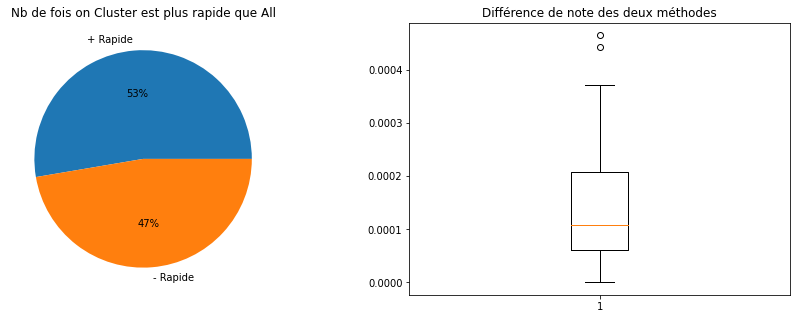

In [77]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.pie([positif, len(delta)-positif], labels=["+ Rapide", "- Rapide"], autopct='%.0f%%')
plt.title("Nb de fois on Cluster est plus rapide que All")

plt.subplot(1, 2, 2)
plt.boxplot(delta)
plt.title("Différence de note des deux méthodes")

plt.show()